# Building the model

In [1]:
%matplotlib inline

import random
import itertools

import numpy as np
import pandas as pd
import patsy

from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from util import get_random_seed, ModelImputer

/home/yasserglez/.virtualenvs/kaggle_titanic/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# random_seed = get_random_seed()
# print('np.random.seed:', random_seed)
np.random.seed(2508464012)

# random_seed = get_random_seed()
# print('random.seed:', random_seed)
random.seed(1726887526)

np.random.seed: 2508464012
random.seed: 1726887526


## Create training and test samples

In [3]:
data = pd.read_csv('clean_data/train.csv')

train, test = train_test_split(data, train_size=0.9)
print('Train:', train.shape[0], 'observations')
print('Test:', test.shape[0], 'observations')

formula = 'Survived ~ Embarked + Class + Fare + Sex + Age + Relatives - 1'
y_train, X_train = patsy.dmatrices(formula, train, NA_action='raise')
y_test, X_test = patsy.dmatrices(formula, test, NA_action='raise')

Train: 800 observations
Test: 89 observations


## Build the model pipeline

In [4]:
pd.DataFrame({'Variable': X_train.design_info.column_names})

,Variable
0,Embarked[Cherbourg]
1,Embarked[Queenstown]
2,Embarked[Southampton]
3,Class[T.second]
4,Class[T.third]
5,Sex[T.male]
6,Fare
7,Age
8,Relatives


In [5]:
pipeline = Pipeline([
    ('fare_imputer', ModelImputer(DecisionTreeRegressor(), 6, [3, 4])),
    ('age_imputer', ModelImputer(DecisionTreeRegressor(), 7)),
    ('forest', RandomForestClassifier()),
])

## Fit the model parameters

In [6]:
param_grid = {'forest__n_estimators': [10, 25, 50, 75, 100],
              'age_imputer__X_columns': []}

X_columns = [[0, 1, 2], [3, 4], [5], [6], [8]]
for k in range(1, len(X_columns)):
    k_combs = [list(itertools.chain(*c)) for c in itertools.combinations(X_columns, k)]
    param_grid['age_imputer__X_columns'].extend(k_combs)
    
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=10, verbose=1)
grid_search.fit(X_train, y_train.ravel())

print('Best accuracy:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

model = grid_search.best_estimator_
joblib.dump(model, 'model/model.pickle');

Best accuracy: 0.82875
Best parameters: {'forest__n_estimators': 50, 'age_imputer__X_columns': [6, 8]}


## Evaluation

In [7]:
y_pred = model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.820224719101


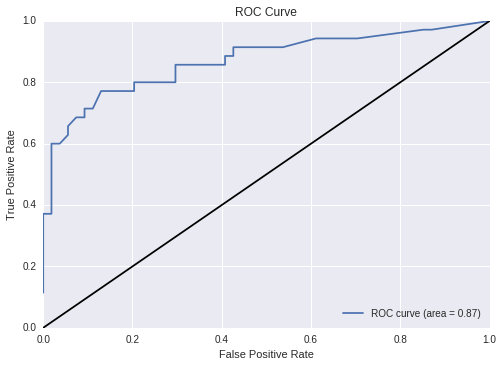

In [8]:
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k-')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')